In [1]:
import numpy as np
import random
import time
import math
import random
import os
import sys
from datetime import datetime

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety
from model_class.UD_clan import *

# Endogamy

## 1. Beta fixed

In [17]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 6
m = 60
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()

for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            UD_endogamy.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                #any_ud_active = False
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    # Only 0
                    contador += 1
                    print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, int(media),0)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Endo_beta_fixed.npy')
np.save(heat_std, mM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Endo_beta_fixed_data.npy')
np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(6, 6)
acabó en el experimento 1 de la media 1.0 con unidades 10.0
acabó en el experimento 2 de la media 1.0 con unidades 10.0
acabó en el experimento 3 de la media 1.0 con unidades 10.0
acabó en el experimento 4 de la media 1.0 con unidades 10.0
acabó en el experimento 5 de la media 1.0 con unidades 10.0
acabó en el experimento 6 de la media 1.0 con unidades 10.0
acabó en el experimento 7 de la media 1.0 con unidades 10.0
acabó en el experimento 8 de la media 1.0 con unidades 10.0
acabó en el experimento 9 de la media 1.0 con unidades 10.0
acabó en el experimento 10 de la media 1.0 con unidades 10.0
acabó en el experimento 11 de la media 1.0 con unidades 10.0
acabó en el experimento 12 de la media 1.0 con unidades 10.0
acabó en el experimento 13 de la media 1.0 con unidades 10.0
acabó en el experimento 14 de la media 1.0 con unidades 10.0
acabó en el experimento 15 de la media 1.0 con unidades 10.0
acabó en el experimento 16 de la media 1.0 con unidades 10.0
acabó en el experimento 17

acabó en el experimento 82 de la media 1.0 con unidades 30.0
acabó en el experimento 83 de la media 1.0 con unidades 30.0
acabó en el experimento 84 de la media 1.0 con unidades 30.0
acabó en el experimento 85 de la media 1.0 con unidades 30.0
acabó en el experimento 86 de la media 1.0 con unidades 30.0
acabó en el experimento 87 de la media 1.0 con unidades 30.0
acabó en el experimento 88 de la media 1.0 con unidades 30.0
acabó en el experimento 89 de la media 1.0 con unidades 30.0
acabó en el experimento 90 de la media 1.0 con unidades 30.0
acabó en el experimento 91 de la media 1.0 con unidades 30.0
acabó en el experimento 92 de la media 1.0 con unidades 30.0
acabó en el experimento 93 de la media 1.0 con unidades 30.0
acabó en el experimento 94 de la media 1.0 con unidades 30.0
acabó en el experimento 95 de la media 1.0 con unidades 30.0
acabó en el experimento 96 de la media 1.0 con unidades 30.0
acabó en el experimento 97 de la media 1.0 con unidades 30.0
acabó en el experimento 

acabó en el experimento 15 de la media 1.0 con unidades 50.0
acabó en el experimento 16 de la media 1.0 con unidades 50.0
acabó en el experimento 17 de la media 1.0 con unidades 50.0
acabó en el experimento 18 de la media 1.0 con unidades 50.0
acabó en el experimento 19 de la media 1.0 con unidades 50.0
acabó en el experimento 20 de la media 1.0 con unidades 50.0
acabó en el experimento 21 de la media 1.0 con unidades 50.0
acabó en el experimento 22 de la media 1.0 con unidades 50.0
acabó en el experimento 23 de la media 1.0 con unidades 50.0
acabó en el experimento 24 de la media 1.0 con unidades 50.0
acabó en el experimento 25 de la media 1.0 con unidades 50.0
acabó en el experimento 26 de la media 1.0 con unidades 50.0
acabó en el experimento 27 de la media 1.0 con unidades 50.0
acabó en el experimento 28 de la media 1.0 con unidades 50.0
acabó en el experimento 29 de la media 1.0 con unidades 50.0
acabó en el experimento 30 de la media 1.0 con unidades 50.0
acabó en el experimento 

acabó en el experimento 49 de la media 1.0 con unidades 60.0
acabó en el experimento 50 de la media 1.0 con unidades 60.0
acabó en el experimento 51 de la media 1.0 con unidades 60.0
acabó en el experimento 52 de la media 1.0 con unidades 60.0
acabó en el experimento 53 de la media 1.0 con unidades 60.0
acabó en el experimento 54 de la media 1.0 con unidades 60.0
acabó en el experimento 55 de la media 1.0 con unidades 60.0
acabó en el experimento 56 de la media 1.0 con unidades 60.0
acabó en el experimento 57 de la media 1.0 con unidades 60.0
acabó en el experimento 58 de la media 1.0 con unidades 60.0
acabó en el experimento 59 de la media 1.0 con unidades 60.0
acabó en el experimento 60 de la media 1.0 con unidades 60.0
acabó en el experimento 61 de la media 1.0 con unidades 60.0
acabó en el experimento 62 de la media 1.0 con unidades 60.0
acabó en el experimento 63 de la media 1.0 con unidades 60.0
acabó en el experimento 64 de la media 1.0 con unidades 60.0
acabó en el experimento 

acabó en el experimento 89 de la media 2.0 con unidades 10.0
acabó en el experimento 90 de la media 2.0 con unidades 10.0
acabó en el experimento 91 de la media 2.0 con unidades 10.0
acabó en el experimento 92 de la media 2.0 con unidades 10.0
acabó en el experimento 93 de la media 2.0 con unidades 10.0
acabó en el experimento 94 de la media 2.0 con unidades 10.0
acabó en el experimento 95 de la media 2.0 con unidades 10.0
acabó en el experimento 96 de la media 2.0 con unidades 10.0
acabó en el experimento 97 de la media 2.0 con unidades 10.0
acabó en el experimento 98 de la media 2.0 con unidades 10.0
acabó en el experimento 99 de la media 2.0 con unidades 10.0
acabó en el experimento 100 de la media 2.0 con unidades 10.0

The total time of the configuration of mean 2.0 and initial UDs 10.0 is  0.7513494491577148
        
acabó en el experimento 1 de la media 2.0 con unidades 20.0
acabó en el experimento 2 de la media 2.0 con unidades 20.0
acabó en el experimento 3 de la media 2.0 con

acabó en el experimento 59 de la media 2.0 con unidades 40.0
acabó en el experimento 60 de la media 2.0 con unidades 40.0
acabó en el experimento 61 de la media 2.0 con unidades 40.0
acabó en el experimento 62 de la media 2.0 con unidades 40.0
acabó en el experimento 63 de la media 2.0 con unidades 40.0
acabó en el experimento 64 de la media 2.0 con unidades 40.0
acabó en el experimento 65 de la media 2.0 con unidades 40.0
acabó en el experimento 66 de la media 2.0 con unidades 40.0
acabó en el experimento 67 de la media 2.0 con unidades 40.0
acabó en el experimento 68 de la media 2.0 con unidades 40.0
acabó en el experimento 69 de la media 2.0 con unidades 40.0
acabó en el experimento 70 de la media 2.0 con unidades 40.0
acabó en el experimento 71 de la media 2.0 con unidades 40.0
acabó en el experimento 72 de la media 2.0 con unidades 40.0
acabó en el experimento 73 de la media 2.0 con unidades 40.0
acabó en el experimento 74 de la media 2.0 con unidades 40.0
acabó en el experimento 

acabó en el experimento 96 de la media 2.0 con unidades 50.0
acabó en el experimento 97 de la media 2.0 con unidades 50.0
acabó en el experimento 98 de la media 2.0 con unidades 50.0
acabó en el experimento 99 de la media 2.0 con unidades 50.0
acabó en el experimento 100 de la media 2.0 con unidades 50.0

The total time of the configuration of mean 2.0 and initial UDs 50.0 is  4.335147380828857
        
acabó en el experimento 1 de la media 2.0 con unidades 60.0
acabó en el experimento 2 de la media 2.0 con unidades 60.0
acabó en el experimento 3 de la media 2.0 con unidades 60.0
acabó en el experimento 4 de la media 2.0 con unidades 60.0
acabó en el experimento 5 de la media 2.0 con unidades 60.0
acabó en el experimento 6 de la media 2.0 con unidades 60.0
acabó en el experimento 7 de la media 2.0 con unidades 60.0
acabó en el experimento 8 de la media 2.0 con unidades 60.0
acabó en el experimento 9 de la media 2.0 con unidades 60.0
acabó en el experimento 10 de la media 2.0 con unidad

acabó en el experimento 38 de la media 3.0 con unidades 10.0
acabó en el experimento 39 de la media 3.0 con unidades 10.0
acabó en el experimento 40 de la media 3.0 con unidades 10.0
acabó en el experimento 41 de la media 3.0 con unidades 10.0
acabó en el experimento 42 de la media 3.0 con unidades 10.0
acabó en el experimento 43 de la media 3.0 con unidades 10.0
acabó en el experimento 44 de la media 3.0 con unidades 10.0
acabó en el experimento 45 de la media 3.0 con unidades 10.0
acabó en el experimento 46 de la media 3.0 con unidades 10.0
acabó en el experimento 47 de la media 3.0 con unidades 10.0
acabó en el experimento 48 de la media 3.0 con unidades 10.0
acabó en el experimento 49 de la media 3.0 con unidades 10.0
acabó en el experimento 50 de la media 3.0 con unidades 10.0
acabó en el experimento 51 de la media 3.0 con unidades 10.0
acabó en el experimento 52 de la media 3.0 con unidades 10.0
acabó en el experimento 53 de la media 3.0 con unidades 10.0
acabó en el experimento 

acabó en el experimento 3 de la media 3.0 con unidades 40.0
acabó en el experimento 4 de la media 3.0 con unidades 40.0
acabó en el experimento 5 de la media 3.0 con unidades 40.0
acabó en el experimento 6 de la media 3.0 con unidades 40.0
acabó en el experimento 7 de la media 3.0 con unidades 40.0
acabó en el experimento 8 de la media 3.0 con unidades 40.0
acabó en el experimento 9 de la media 3.0 con unidades 40.0
acabó en el experimento 10 de la media 3.0 con unidades 40.0
acabó en el experimento 11 de la media 3.0 con unidades 40.0
acabó en el experimento 12 de la media 3.0 con unidades 40.0
acabó en el experimento 13 de la media 3.0 con unidades 40.0
acabó en el experimento 14 de la media 3.0 con unidades 40.0
acabó en el experimento 15 de la media 3.0 con unidades 40.0
acabó en el experimento 16 de la media 3.0 con unidades 40.0
acabó en el experimento 17 de la media 3.0 con unidades 40.0
acabó en el experimento 18 de la media 3.0 con unidades 40.0
acabó en el experimento 19 de l

acabó en el experimento 36 de la media 3.0 con unidades 50.0
acabó en el experimento 37 de la media 3.0 con unidades 50.0
acabó en el experimento 38 de la media 3.0 con unidades 50.0
acabó en el experimento 39 de la media 3.0 con unidades 50.0
acabó en el experimento 40 de la media 3.0 con unidades 50.0
acabó en el experimento 41 de la media 3.0 con unidades 50.0
acabó en el experimento 42 de la media 3.0 con unidades 50.0
acabó en el experimento 43 de la media 3.0 con unidades 50.0
acabó en el experimento 44 de la media 3.0 con unidades 50.0
acabó en el experimento 45 de la media 3.0 con unidades 50.0
acabó en el experimento 46 de la media 3.0 con unidades 50.0
acabó en el experimento 47 de la media 3.0 con unidades 50.0
acabó en el experimento 48 de la media 3.0 con unidades 50.0
acabó en el experimento 49 de la media 3.0 con unidades 50.0
acabó en el experimento 50 de la media 3.0 con unidades 50.0
acabó en el experimento 51 de la media 3.0 con unidades 50.0
acabó en el experimento 

acabó en el experimento 70 de la media 3.0 con unidades 60.0
acabó en el experimento 71 de la media 3.0 con unidades 60.0
acabó en el experimento 72 de la media 3.0 con unidades 60.0
acabó en el experimento 73 de la media 3.0 con unidades 60.0
acabó en el experimento 74 de la media 3.0 con unidades 60.0
acabó en el experimento 75 de la media 3.0 con unidades 60.0
acabó en el experimento 76 de la media 3.0 con unidades 60.0
acabó en el experimento 77 de la media 3.0 con unidades 60.0
acabó en el experimento 78 de la media 3.0 con unidades 60.0
acabó en el experimento 79 de la media 3.0 con unidades 60.0
acabó en el experimento 80 de la media 3.0 con unidades 60.0
acabó en el experimento 81 de la media 3.0 con unidades 60.0
acabó en el experimento 82 de la media 3.0 con unidades 60.0
acabó en el experimento 83 de la media 3.0 con unidades 60.0
acabó en el experimento 84 de la media 3.0 con unidades 60.0
acabó en el experimento 85 de la media 3.0 con unidades 60.0
acabó en el experimento 

acabó en el experimento 55 de la media 4.0 con unidades 30.0
acabó en el experimento 57 de la media 4.0 con unidades 30.0
acabó en el experimento 58 de la media 4.0 con unidades 30.0
acabó en el experimento 64 de la media 4.0 con unidades 30.0
acabó en el experimento 81 de la media 4.0 con unidades 30.0
acabó en el experimento 83 de la media 4.0 con unidades 30.0

The total time of the configuration of mean 4.0 and initial UDs 30.0 is  443.766398191452
        
acabó en el experimento 39 de la media 4.0 con unidades 40.0
acabó en el experimento 46 de la media 4.0 con unidades 40.0
acabó en el experimento 78 de la media 4.0 con unidades 40.0

The total time of the configuration of mean 4.0 and initial UDs 40.0 is  593.611123085022
        
acabó en el experimento 25 de la media 4.0 con unidades 50.0
acabó en el experimento 47 de la media 4.0 con unidades 50.0

The total time of the configuration of mean 4.0 and initial UDs 50.0 is  840.4844393730164
        

The total time of the confi

In [2]:
# Dowload the documents
#As a reference
n = 6
m = 60
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Endo_beta_fixed.npy')
behavior = os.path.join(folder_name, 'Endo_beta_fixed_data.npy')
## heatmap and mean
mM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
mM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Unidades iniciais')

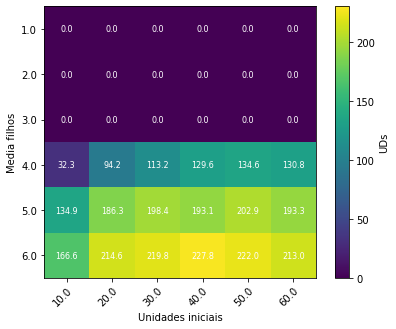

In [3]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

Text(0.5, 0, 'Unidades iniciais')

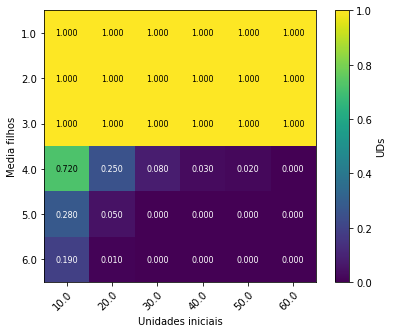

In [4]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.3f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

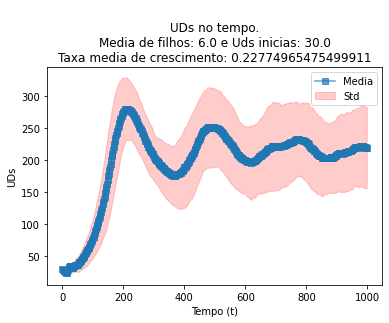

In [25]:
#Graph of experiment with mean and std
x = 2
y = 5

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## 2. UDs fixed

In [26]:
#This experiment has Uds inicias in 40
iniciais = 40
n = 6
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.055 to 0.075
uM = np.empty((len(ualphas), len(ubetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

start = time.time()
# For data of behaviour
datos_2 = np.empty((len(ualphas), len(ubetas)), dtype=object)
print(uM.shape)

for i, media in enumerate(ualphas):
    for j, prob_morte  in enumerate(ubetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            UD_endogamy.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD_endogamy(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)
                if not uds_copy:
                    contador += 1
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, int(media),0)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        uM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_2[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {original_media} and beta {prob_morte:.3f} is  {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Endo_UDin_fixed.npy')
np.save(heat_std, uM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Endo_Udin_fixed_data.npy')
np.save(behavior, datos_2)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(6, 5)

The total time of the configuration of mean 1.0 and beta 0.055 is  1.6759650707244873
        

The total time of the configuration of mean 1.0 and beta 0.060 is  1.467198371887207
        

The total time of the configuration of mean 1.0 and beta 0.065 is  1.2212896347045898
        

The total time of the configuration of mean 1.0 and beta 0.070 is  1.0029098987579346
        

The total time of the configuration of mean 1.0 and beta 0.075 is  0.8769991397857666
        

The total time of the configuration of mean 2.0 and beta 0.055 is  3.4190311431884766
        

The total time of the configuration of mean 2.0 and beta 0.060 is  2.9752871990203857
        

The total time of the configuration of mean 2.0 and beta 0.065 is  2.416940212249756
        

The total time of the configuration of mean 2.0 and beta 0.070 is  2.3325231075286865
        

The total time of the configuration of mean 2.0 and beta 0.075 is  2.0336408615112305
        

The total time of the configuratio

In [7]:
# Dowload the documents
#As reference
n = 6
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.055 to 0.075
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Endo_UDin_fixed.npy')
behavior = os.path.join(folder_name, 'Endo_Udin_fixed_data.npy')
## heatmap and mean
uM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
uM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

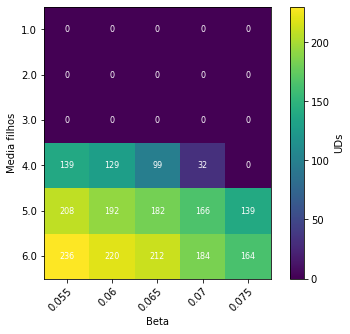

In [8]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

Text(0.5, 0, 'Beta')

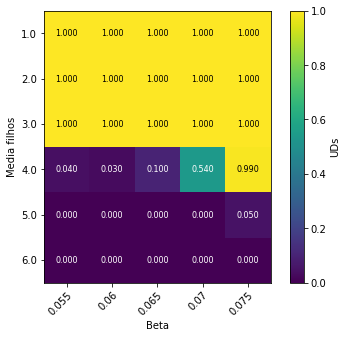

In [7]:
#Heatmap. 
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.3f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

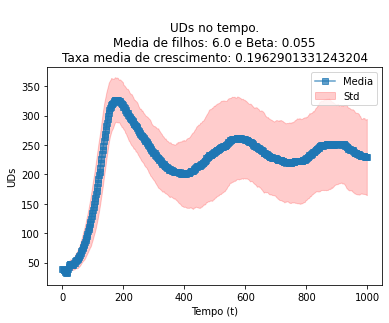

In [25]:
#Graph for each experiment
x = 0
y = 5

# Mean line
plt.plot(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'] - uM_behavior[y][x]['std'],
                 uM_behavior[y][x]['mean'] + uM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {ualphas[y]} e Beta: {ubetas[x]:.3f}
Taxa media de crescimento: {uM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## 3. Mean fixed

In [12]:
#This experiment has mean of children: 4
media = 4
n = 60
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 60
hbetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
hM = np.empty((len(halphas), len(hbetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

start = time.time()
# For data of behaviour
datos_3 = np.empty((len(halphas), len(hbetas)), dtype=object)

for i, iniciais in enumerate(halphas):
    for j, prob_morte  in enumerate(hbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            UD_endogamy.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_endogamy(id_ud, media))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_endogamy.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_endogamy.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_endogamy.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)  
                if not uds_copy:
                    contador += 1
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, int(media),0)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        hM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_3[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of Initial UDs {iniciais} and beta {prob_morte:.3f} is: {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Endo_Mean_fixed.npy')
np.save(heat_std, hM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Endo_Mean_fixed_data.npy')
np.save(behavior, datos_3)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")


The total time of the configuration of Initial UDs 10.0 and beta 0.055 is: 239.67869329452515
        

The total time of the configuration of Initial UDs 10.0 and beta 0.060 is: 155.47089862823486
        

The total time of the configuration of Initial UDs 10.0 and beta 0.065 is: 33.956358671188354
        

The total time of the configuration of Initial UDs 10.0 and beta 0.070 is: 3.75600528717041
        

The total time of the configuration of Initial UDs 10.0 and beta 0.075 is: 1.3396730422973633
        

The total time of the configuration of Initial UDs 20.0 and beta 0.055 is: 587.3309595584869
        

The total time of the configuration of Initial UDs 20.0 and beta 0.060 is: 387.2619867324829
        

The total time of the configuration of Initial UDs 20.0 and beta 0.065 is: 154.03034663200378
        

The total time of the configuration of Initial UDs 20.0 and beta 0.070 is: 24.797226428985596
        

The total time of the configuration of Initial UDs 20.0 and beta 0.

In [9]:
# Dowload the documents
#As reference
n = 60
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.055 to 0.075
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Endo_Mean_fixed.npy')
behavior = os.path.join(folder_name, 'Endo_Mean_fixed_data.npy')
## heatmap and mean
hM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
hM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

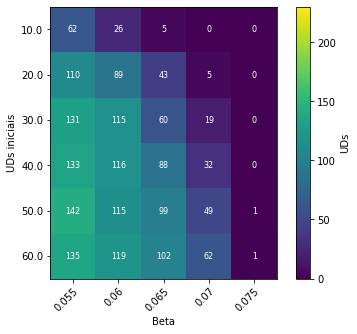

In [10]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

Text(0.5, 0, 'Beta')

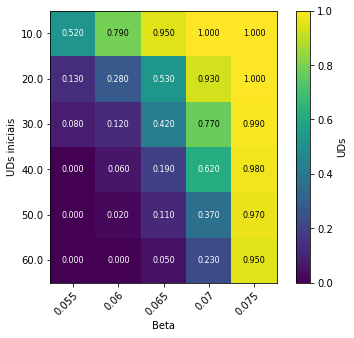

In [7]:
#Heatmap. 
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.3f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

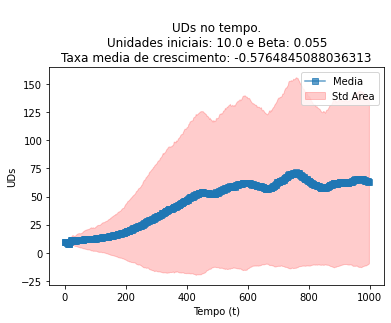

In [8]:
x = 0
y = 0

# MEan line
plt.plot(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'] - hM_behavior[y][x]['std'],
                 hM_behavior[y][x]['mean'] + hM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std Area')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Unidades iniciais: {halphas[y]} e Beta: {hbetas[x]:.3f}
Taxa media de crescimento: {hM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

# Dual organization

## 1. Beta fixed

In [9]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 6
m = 60
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()

for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            clanes = [1,2]
            clans = (clanes * (int(iniciais) // 2)) + clanes[:(int(iniciais) % 2)]
            random.shuffle(clans)
            UD_dual_organization.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)    
                if not uds_copy:
                    contador += 1
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    any_ud_active = True
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, int(media),0 , True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Dual_beta_fixed.npy')
np.save(heat_std, mM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Dual_beta_fixed_data.npy')
np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(6, 6)
acabó en el experimento 1 de la media 1.0 con unidades 10.0
acabó en el experimento 2 de la media 1.0 con unidades 10.0
acabó en el experimento 3 de la media 1.0 con unidades 10.0
acabó en el experimento 4 de la media 1.0 con unidades 10.0
acabó en el experimento 5 de la media 1.0 con unidades 10.0
acabó en el experimento 6 de la media 1.0 con unidades 10.0
acabó en el experimento 7 de la media 1.0 con unidades 10.0
acabó en el experimento 8 de la media 1.0 con unidades 10.0
acabó en el experimento 9 de la media 1.0 con unidades 10.0
acabó en el experimento 10 de la media 1.0 con unidades 10.0
acabó en el experimento 11 de la media 1.0 con unidades 10.0
acabó en el experimento 12 de la media 1.0 con unidades 10.0
acabó en el experimento 13 de la media 1.0 con unidades 10.0
acabó en el experimento 14 de la media 1.0 con unidades 10.0
acabó en el experimento 15 de la media 1.0 con unidades 10.0
acabó en el experimento 16 de la media 1.0 con unidades 10.0
acabó en el experimento 17

acabó en el experimento 39 de la media 1.0 con unidades 20.0
acabó en el experimento 40 de la media 1.0 con unidades 20.0
acabó en el experimento 41 de la media 1.0 con unidades 20.0
acabó en el experimento 42 de la media 1.0 con unidades 20.0
acabó en el experimento 43 de la media 1.0 con unidades 20.0
acabó en el experimento 44 de la media 1.0 con unidades 20.0
acabó en el experimento 45 de la media 1.0 con unidades 20.0
acabó en el experimento 46 de la media 1.0 con unidades 20.0
acabó en el experimento 47 de la media 1.0 con unidades 20.0
acabó en el experimento 48 de la media 1.0 con unidades 20.0
acabó en el experimento 49 de la media 1.0 con unidades 20.0
acabó en el experimento 50 de la media 1.0 con unidades 20.0
acabó en el experimento 51 de la media 1.0 con unidades 20.0
acabó en el experimento 52 de la media 1.0 con unidades 20.0
acabó en el experimento 53 de la media 1.0 con unidades 20.0
acabó en el experimento 54 de la media 1.0 con unidades 20.0
acabó en el experimento 

acabó en el experimento 72 de la media 1.0 con unidades 30.0
acabó en el experimento 73 de la media 1.0 con unidades 30.0
acabó en el experimento 74 de la media 1.0 con unidades 30.0
acabó en el experimento 75 de la media 1.0 con unidades 30.0
acabó en el experimento 76 de la media 1.0 con unidades 30.0
acabó en el experimento 77 de la media 1.0 con unidades 30.0
acabó en el experimento 78 de la media 1.0 con unidades 30.0
acabó en el experimento 79 de la media 1.0 con unidades 30.0
acabó en el experimento 80 de la media 1.0 con unidades 30.0
acabó en el experimento 81 de la media 1.0 con unidades 30.0
acabó en el experimento 82 de la media 1.0 con unidades 30.0
acabó en el experimento 83 de la media 1.0 con unidades 30.0
acabó en el experimento 84 de la media 1.0 con unidades 30.0
acabó en el experimento 85 de la media 1.0 con unidades 30.0
acabó en el experimento 86 de la media 1.0 con unidades 30.0
acabó en el experimento 87 de la media 1.0 con unidades 30.0
acabó en el experimento 

acabó en el experimento 6 de la media 1.0 con unidades 50.0
acabó en el experimento 7 de la media 1.0 con unidades 50.0
acabó en el experimento 8 de la media 1.0 con unidades 50.0
acabó en el experimento 9 de la media 1.0 con unidades 50.0
acabó en el experimento 10 de la media 1.0 con unidades 50.0
acabó en el experimento 11 de la media 1.0 con unidades 50.0
acabó en el experimento 12 de la media 1.0 con unidades 50.0
acabó en el experimento 13 de la media 1.0 con unidades 50.0
acabó en el experimento 14 de la media 1.0 con unidades 50.0
acabó en el experimento 15 de la media 1.0 con unidades 50.0
acabó en el experimento 16 de la media 1.0 con unidades 50.0
acabó en el experimento 17 de la media 1.0 con unidades 50.0
acabó en el experimento 18 de la media 1.0 con unidades 50.0
acabó en el experimento 19 de la media 1.0 con unidades 50.0
acabó en el experimento 20 de la media 1.0 con unidades 50.0
acabó en el experimento 21 de la media 1.0 con unidades 50.0
acabó en el experimento 22 d

acabó en el experimento 40 de la media 1.0 con unidades 60.0
acabó en el experimento 41 de la media 1.0 con unidades 60.0
acabó en el experimento 42 de la media 1.0 con unidades 60.0
acabó en el experimento 43 de la media 1.0 con unidades 60.0
acabó en el experimento 44 de la media 1.0 con unidades 60.0
acabó en el experimento 45 de la media 1.0 con unidades 60.0
acabó en el experimento 46 de la media 1.0 con unidades 60.0
acabó en el experimento 47 de la media 1.0 con unidades 60.0
acabó en el experimento 48 de la media 1.0 con unidades 60.0
acabó en el experimento 49 de la media 1.0 con unidades 60.0
acabó en el experimento 50 de la media 1.0 con unidades 60.0
acabó en el experimento 51 de la media 1.0 con unidades 60.0
acabó en el experimento 52 de la media 1.0 con unidades 60.0
acabó en el experimento 53 de la media 1.0 con unidades 60.0
acabó en el experimento 54 de la media 1.0 con unidades 60.0
acabó en el experimento 55 de la media 1.0 con unidades 60.0
acabó en el experimento 

acabó en el experimento 74 de la media 2.0 con unidades 10.0
acabó en el experimento 75 de la media 2.0 con unidades 10.0
acabó en el experimento 76 de la media 2.0 con unidades 10.0
acabó en el experimento 77 de la media 2.0 con unidades 10.0
acabó en el experimento 78 de la media 2.0 con unidades 10.0
acabó en el experimento 79 de la media 2.0 con unidades 10.0
acabó en el experimento 80 de la media 2.0 con unidades 10.0
acabó en el experimento 81 de la media 2.0 con unidades 10.0
acabó en el experimento 82 de la media 2.0 con unidades 10.0
acabó en el experimento 83 de la media 2.0 con unidades 10.0
acabó en el experimento 84 de la media 2.0 con unidades 10.0
acabó en el experimento 85 de la media 2.0 con unidades 10.0
acabó en el experimento 86 de la media 2.0 con unidades 10.0
acabó en el experimento 87 de la media 2.0 con unidades 10.0
acabó en el experimento 88 de la media 2.0 con unidades 10.0
acabó en el experimento 89 de la media 2.0 con unidades 10.0
acabó en el experimento 

acabó en el experimento 13 de la media 2.0 con unidades 30.0
acabó en el experimento 14 de la media 2.0 con unidades 30.0
acabó en el experimento 15 de la media 2.0 con unidades 30.0
acabó en el experimento 16 de la media 2.0 con unidades 30.0
acabó en el experimento 17 de la media 2.0 con unidades 30.0
acabó en el experimento 18 de la media 2.0 con unidades 30.0
acabó en el experimento 19 de la media 2.0 con unidades 30.0
acabó en el experimento 20 de la media 2.0 con unidades 30.0
acabó en el experimento 21 de la media 2.0 con unidades 30.0
acabó en el experimento 22 de la media 2.0 con unidades 30.0
acabó en el experimento 23 de la media 2.0 con unidades 30.0
acabó en el experimento 24 de la media 2.0 con unidades 30.0
acabó en el experimento 25 de la media 2.0 con unidades 30.0
acabó en el experimento 26 de la media 2.0 con unidades 30.0
acabó en el experimento 27 de la media 2.0 con unidades 30.0
acabó en el experimento 28 de la media 2.0 con unidades 30.0
acabó en el experimento 

acabó en el experimento 47 de la media 2.0 con unidades 40.0
acabó en el experimento 48 de la media 2.0 con unidades 40.0
acabó en el experimento 49 de la media 2.0 con unidades 40.0
acabó en el experimento 50 de la media 2.0 con unidades 40.0
acabó en el experimento 51 de la media 2.0 con unidades 40.0
acabó en el experimento 52 de la media 2.0 con unidades 40.0
acabó en el experimento 53 de la media 2.0 con unidades 40.0
acabó en el experimento 54 de la media 2.0 con unidades 40.0
acabó en el experimento 55 de la media 2.0 con unidades 40.0
acabó en el experimento 56 de la media 2.0 con unidades 40.0
acabó en el experimento 57 de la media 2.0 con unidades 40.0
acabó en el experimento 58 de la media 2.0 con unidades 40.0
acabó en el experimento 59 de la media 2.0 con unidades 40.0
acabó en el experimento 60 de la media 2.0 con unidades 40.0
acabó en el experimento 61 de la media 2.0 con unidades 40.0
acabó en el experimento 62 de la media 2.0 con unidades 40.0
acabó en el experimento 

acabó en el experimento 80 de la media 2.0 con unidades 50.0
acabó en el experimento 81 de la media 2.0 con unidades 50.0
acabó en el experimento 82 de la media 2.0 con unidades 50.0
acabó en el experimento 83 de la media 2.0 con unidades 50.0
acabó en el experimento 84 de la media 2.0 con unidades 50.0
acabó en el experimento 85 de la media 2.0 con unidades 50.0
acabó en el experimento 86 de la media 2.0 con unidades 50.0
acabó en el experimento 87 de la media 2.0 con unidades 50.0
acabó en el experimento 88 de la media 2.0 con unidades 50.0
acabó en el experimento 89 de la media 2.0 con unidades 50.0
acabó en el experimento 90 de la media 2.0 con unidades 50.0
acabó en el experimento 91 de la media 2.0 con unidades 50.0
acabó en el experimento 92 de la media 2.0 con unidades 50.0
acabó en el experimento 93 de la media 2.0 con unidades 50.0
acabó en el experimento 94 de la media 2.0 con unidades 50.0
acabó en el experimento 95 de la media 2.0 con unidades 50.0
acabó en el experimento 

acabó en el experimento 25 de la media 3.0 con unidades 10.0
acabó en el experimento 26 de la media 3.0 con unidades 10.0
acabó en el experimento 27 de la media 3.0 con unidades 10.0
acabó en el experimento 28 de la media 3.0 con unidades 10.0
acabó en el experimento 29 de la media 3.0 con unidades 10.0
acabó en el experimento 30 de la media 3.0 con unidades 10.0
acabó en el experimento 31 de la media 3.0 con unidades 10.0
acabó en el experimento 32 de la media 3.0 con unidades 10.0
acabó en el experimento 33 de la media 3.0 con unidades 10.0
acabó en el experimento 34 de la media 3.0 con unidades 10.0
acabó en el experimento 35 de la media 3.0 con unidades 10.0
acabó en el experimento 36 de la media 3.0 con unidades 10.0
acabó en el experimento 37 de la media 3.0 con unidades 10.0
acabó en el experimento 38 de la media 3.0 con unidades 10.0
acabó en el experimento 39 de la media 3.0 con unidades 10.0
acabó en el experimento 40 de la media 3.0 con unidades 10.0
acabó en el experimento 

acabó en el experimento 60 de la media 3.0 con unidades 20.0
acabó en el experimento 61 de la media 3.0 con unidades 20.0
acabó en el experimento 62 de la media 3.0 con unidades 20.0
acabó en el experimento 63 de la media 3.0 con unidades 20.0
acabó en el experimento 64 de la media 3.0 con unidades 20.0
acabó en el experimento 65 de la media 3.0 con unidades 20.0
acabó en el experimento 66 de la media 3.0 con unidades 20.0
acabó en el experimento 67 de la media 3.0 con unidades 20.0
acabó en el experimento 68 de la media 3.0 con unidades 20.0
acabó en el experimento 69 de la media 3.0 con unidades 20.0
acabó en el experimento 70 de la media 3.0 con unidades 20.0
acabó en el experimento 71 de la media 3.0 con unidades 20.0
acabó en el experimento 72 de la media 3.0 con unidades 20.0
acabó en el experimento 73 de la media 3.0 con unidades 20.0
acabó en el experimento 74 de la media 3.0 con unidades 20.0
acabó en el experimento 75 de la media 3.0 con unidades 20.0
acabó en el experimento 

acabó en el experimento 94 de la media 3.0 con unidades 30.0
acabó en el experimento 95 de la media 3.0 con unidades 30.0
acabó en el experimento 96 de la media 3.0 con unidades 30.0
acabó en el experimento 97 de la media 3.0 con unidades 30.0
acabó en el experimento 98 de la media 3.0 con unidades 30.0
acabó en el experimento 99 de la media 3.0 con unidades 30.0
acabó en el experimento 100 de la media 3.0 con unidades 30.0

The total time of the configuration of mean 3.0 and initial UDs 30.0 is  7.366761922836304
        
acabó en el experimento 1 de la media 3.0 con unidades 40.0
acabó en el experimento 2 de la media 3.0 con unidades 40.0
acabó en el experimento 3 de la media 3.0 con unidades 40.0
acabó en el experimento 4 de la media 3.0 con unidades 40.0
acabó en el experimento 5 de la media 3.0 con unidades 40.0
acabó en el experimento 6 de la media 3.0 con unidades 40.0
acabó en el experimento 7 de la media 3.0 con unidades 40.0
acabó en el experimento 8 de la media 3.0 con unida

acabó en el experimento 27 de la media 3.0 con unidades 50.0
acabó en el experimento 28 de la media 3.0 con unidades 50.0
acabó en el experimento 29 de la media 3.0 con unidades 50.0
acabó en el experimento 30 de la media 3.0 con unidades 50.0
acabó en el experimento 31 de la media 3.0 con unidades 50.0
acabó en el experimento 32 de la media 3.0 con unidades 50.0
acabó en el experimento 33 de la media 3.0 con unidades 50.0
acabó en el experimento 34 de la media 3.0 con unidades 50.0
acabó en el experimento 35 de la media 3.0 con unidades 50.0
acabó en el experimento 36 de la media 3.0 con unidades 50.0
acabó en el experimento 37 de la media 3.0 con unidades 50.0
acabó en el experimento 38 de la media 3.0 con unidades 50.0
acabó en el experimento 39 de la media 3.0 con unidades 50.0
acabó en el experimento 40 de la media 3.0 con unidades 50.0
acabó en el experimento 41 de la media 3.0 con unidades 50.0
acabó en el experimento 42 de la media 3.0 con unidades 50.0
acabó en el experimento 

acabó en el experimento 61 de la media 3.0 con unidades 60.0
acabó en el experimento 62 de la media 3.0 con unidades 60.0
acabó en el experimento 63 de la media 3.0 con unidades 60.0
acabó en el experimento 64 de la media 3.0 con unidades 60.0
acabó en el experimento 65 de la media 3.0 con unidades 60.0
acabó en el experimento 66 de la media 3.0 con unidades 60.0
acabó en el experimento 67 de la media 3.0 con unidades 60.0
acabó en el experimento 68 de la media 3.0 con unidades 60.0
acabó en el experimento 69 de la media 3.0 con unidades 60.0
acabó en el experimento 70 de la media 3.0 con unidades 60.0
acabó en el experimento 71 de la media 3.0 con unidades 60.0
acabó en el experimento 72 de la media 3.0 con unidades 60.0
acabó en el experimento 73 de la media 3.0 con unidades 60.0
acabó en el experimento 74 de la media 3.0 con unidades 60.0
acabó en el experimento 75 de la media 3.0 con unidades 60.0
acabó en el experimento 76 de la media 3.0 con unidades 60.0
acabó en el experimento 

acabó en el experimento 3 de la media 4.0 con unidades 20.0
acabó en el experimento 4 de la media 4.0 con unidades 20.0
acabó en el experimento 6 de la media 4.0 con unidades 20.0
acabó en el experimento 7 de la media 4.0 con unidades 20.0
acabó en el experimento 8 de la media 4.0 con unidades 20.0
acabó en el experimento 9 de la media 4.0 con unidades 20.0
acabó en el experimento 10 de la media 4.0 con unidades 20.0
acabó en el experimento 11 de la media 4.0 con unidades 20.0
acabó en el experimento 12 de la media 4.0 con unidades 20.0
acabó en el experimento 13 de la media 4.0 con unidades 20.0
acabó en el experimento 14 de la media 4.0 con unidades 20.0
acabó en el experimento 15 de la media 4.0 con unidades 20.0
acabó en el experimento 17 de la media 4.0 con unidades 20.0
acabó en el experimento 18 de la media 4.0 con unidades 20.0
acabó en el experimento 20 de la media 4.0 con unidades 20.0
acabó en el experimento 21 de la media 4.0 con unidades 20.0
acabó en el experimento 22 de 


The total time of the configuration of mean 4.0 and initial UDs 60.0 is  687.6091330051422
        
acabó en el experimento 3 de la media 5.0 con unidades 10.0
acabó en el experimento 4 de la media 5.0 con unidades 10.0
acabó en el experimento 6 de la media 5.0 con unidades 10.0
acabó en el experimento 8 de la media 5.0 con unidades 10.0
acabó en el experimento 14 de la media 5.0 con unidades 10.0
acabó en el experimento 15 de la media 5.0 con unidades 10.0
acabó en el experimento 16 de la media 5.0 con unidades 10.0
acabó en el experimento 18 de la media 5.0 con unidades 10.0
acabó en el experimento 19 de la media 5.0 con unidades 10.0
acabó en el experimento 22 de la media 5.0 con unidades 10.0
acabó en el experimento 24 de la media 5.0 con unidades 10.0
acabó en el experimento 25 de la media 5.0 con unidades 10.0
acabó en el experimento 27 de la media 5.0 con unidades 10.0
acabó en el experimento 29 de la media 5.0 con unidades 10.0
acabó en el experimento 31 de la media 5.0 con un

acabó en el experimento 75 de la media 6.0 con unidades 30.0

The total time of the configuration of mean 6.0 and initial UDs 30.0 is  1794.5775294303894
        

The total time of the configuration of mean 6.0 and initial UDs 40.0 is  1782.8811435699463
        

The total time of the configuration of mean 6.0 and initial UDs 50.0 is  1785.609980583191
        

The total time of the configuration of mean 6.0 and initial UDs 60.0 is  1819.4200568199158
        

It finished at: 2024-10-10 13:10:33.427227
It lasted 19772.559406757355

done


In [11]:
# Dowload the documents
#As a reference
n = 6
m = 60
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Dual_beta_fixed.npy')
behavior = os.path.join(folder_name, 'Dual_beta_fixed_data.npy')
## heatmap and mean
mM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
mM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Unidades iniciais')

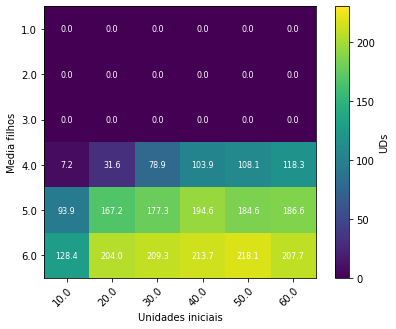

In [12]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

Text(0.5, 0, 'Unidades iniciais')

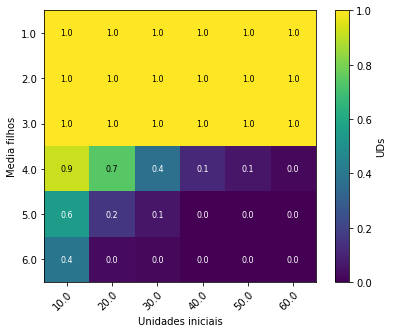

In [15]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

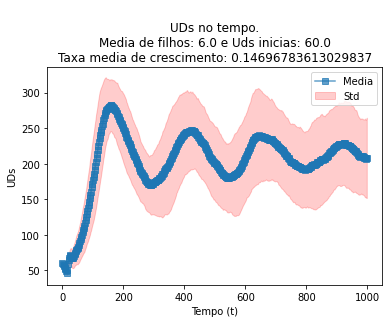

In [16]:
#Graph of experiment with mean and std
x = 5
y = 5

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## 2. UDs fixed

In [17]:
#This experiment has Uds inicias in 40
iniciais = 40
n = 6
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
uM = np.empty((len(ualphas), len(ubetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

start = time.time()
# For data of behaviour
datos_2 = np.empty((len(ualphas), len(ubetas)), dtype=object)
print(uM.shape)

for i, media in enumerate(ualphas):
    for j, prob_morte  in enumerate(ubetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            clanes = [1,2]
            clans = (clanes * (int(iniciais) // 2)) + clanes[:(int(iniciais) % 2)]
            random.shuffle(clans)
            UD_dual_organization.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                #any_ud_active = False
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)  
                if not uds_copy:
                    contador += 1
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, int(media),0 , True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        uM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_2[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {original_media} and beta {prob_morte:.3f} is  {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Dual_UDin_fixed.npy')
np.save(heat_std, uM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Dual_Udin_fixed_data.npy')
np.save(behavior, datos_2)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(6, 5)

The total time of the configuration of mean 1.0 and beta 0.055 is  1.9032671451568604
        

The total time of the configuration of mean 1.0 and beta 0.060 is  1.9826180934906006
        

The total time of the configuration of mean 1.0 and beta 0.065 is  1.7425575256347656
        

The total time of the configuration of mean 1.0 and beta 0.070 is  2.0474367141723633
        

The total time of the configuration of mean 1.0 and beta 0.075 is  1.7601394653320312
        

The total time of the configuration of mean 2.0 and beta 0.055 is  5.261042594909668
        

The total time of the configuration of mean 2.0 and beta 0.060 is  4.281798601150513
        

The total time of the configuration of mean 2.0 and beta 0.065 is  4.292961835861206
        

The total time of the configuration of mean 2.0 and beta 0.070 is  4.624895095825195
        

The total time of the configuration of mean 2.0 and beta 0.075 is  2.8931801319122314
        

The total time of the configuration 

In [13]:
# Dowload the documents
#As reference
n = 6
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Dual_UDin_fixed.npy')
behavior = os.path.join(folder_name, 'Dual_Udin_fixed_data.npy')
## heatmap and mean
uM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
uM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

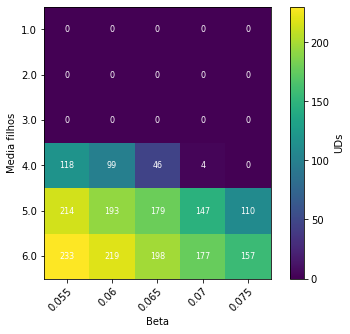

In [14]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

Text(0.5, 0, 'Beta')

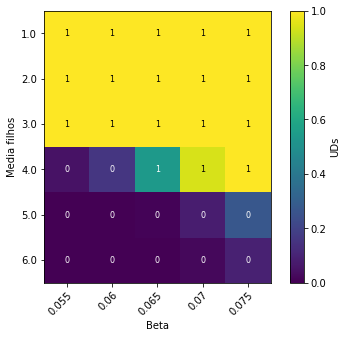

In [23]:
#Heatmap. 
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

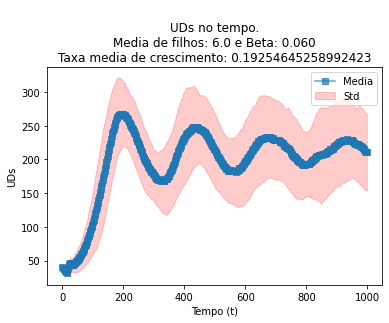

In [6]:
#Graph for each experiment
x = 1
y = 5

# Mean line
plt.plot(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'] - uM_behavior[y][x]['std'],
                 uM_behavior[y][x]['mean'] + uM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {ualphas[y]} e Beta: {ubetas[x]:.3f}
Taxa media de crescimento: {uM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## 3. Mean fixed

In [22]:
#This experiment has mean of children: 4
media = 4
n = 60
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.055 to 0.075
hM = np.empty((len(halphas), len(hbetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

start = time.time()
# For data of behaviour
datos_3 = np.empty((len(halphas), len(hbetas)), dtype=object)
print(hM.shape)

for i, iniciais in enumerate(halphas):
    for j, prob_morte  in enumerate(hbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            clanes = [1,2]
            clans = (clanes * (int(iniciais) // 2)) + clanes[:(int(iniciais) % 2)]
            random.shuffle(clans)
            UD_dual_organization.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_dual_organization.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_dual_organization.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)  
                if not uds_copy:
                    contador += 1
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, int(media),0 , True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        hM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_3[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of Initial UDs {iniciais} and beta {prob_morte:.3f} is: {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Dual_Mean_fixed.npy')
np.save(heat_std, hM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Dual_Mean_fixed_data.npy')
np.save(behavior, datos_3)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(6, 5)

The total time of the configuration of Initial UDs 10.0 and beta 0.055 is: 122.143137216568
        

The total time of the configuration of Initial UDs 10.0 and beta 0.060 is: 44.00128960609436
        

The total time of the configuration of Initial UDs 10.0 and beta 0.065 is: 2.8362138271331787
        

The total time of the configuration of Initial UDs 10.0 and beta 0.070 is: 1.634619951248169
        

The total time of the configuration of Initial UDs 10.0 and beta 0.075 is: 0.946338415145874
        

The total time of the configuration of Initial UDs 20.0 and beta 0.055 is: 400.03259921073914
        

The total time of the configuration of Initial UDs 20.0 and beta 0.060 is: 237.61161375045776
        

The total time of the configuration of Initial UDs 20.0 and beta 0.065 is: 57.18506836891174
        

The total time of the configuration of Initial UDs 20.0 and beta 0.070 is: 7.779039144515991
        

The total time of the configuration of Initial UDs 20.0 and bet

In [23]:
# Dowload the documents
#As reference
n = 60
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to n
hbetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.055 to 0.075
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Dual_Mean_fixed.npy')
behavior = os.path.join(folder_name, 'Dual_Mean_fixed_data.npy')
## heatmap and mean
hM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
hM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

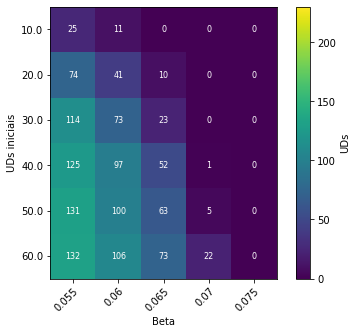

In [24]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

Text(0.5, 0, 'Beta')

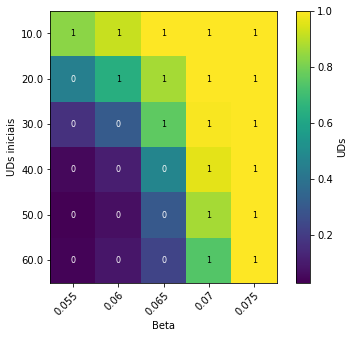

In [25]:
#Heatmap. 
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

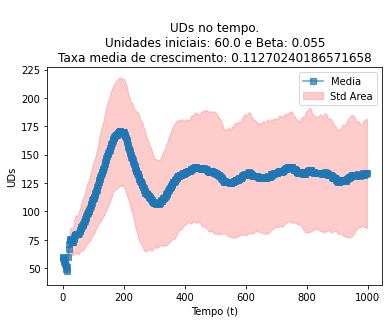

In [9]:
x = 0
y = 5

# MEan line
plt.plot(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'] - hM_behavior[y][x]['std'],
                 hM_behavior[y][x]['mean'] + hM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std Area')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Unidades iniciais: {halphas[y]} e Beta: {hbetas[x]:.3f}
Taxa media de crescimento: {hM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

# Generalized

## 1. Beta fixed

In [29]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 6
m = 60
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()

for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            clanes = [1,2,3]
            clans = (clanes * (int(iniciais) // 3)) + clanes[:(int(iniciais) % 3)]# Just 3 clans
            random.shuffle(clans)
            UD_generalized.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    print(media)    
                if not uds_copy:
                    contador += 1
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    any_ud_active = True
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, 0, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Generalized_beta_fixed.npy')
np.save(heat_std, mM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Generalized_beta_fixed_data.npy')
np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(6, 6)
acabó en el experimento 1 de la media 1.0 con unidades 10.0
acabó en el experimento 2 de la media 1.0 con unidades 10.0
acabó en el experimento 3 de la media 1.0 con unidades 10.0
acabó en el experimento 4 de la media 1.0 con unidades 10.0
acabó en el experimento 5 de la media 1.0 con unidades 10.0
acabó en el experimento 6 de la media 1.0 con unidades 10.0
acabó en el experimento 7 de la media 1.0 con unidades 10.0
acabó en el experimento 8 de la media 1.0 con unidades 10.0
acabó en el experimento 9 de la media 1.0 con unidades 10.0
acabó en el experimento 10 de la media 1.0 con unidades 10.0
acabó en el experimento 11 de la media 1.0 con unidades 10.0
acabó en el experimento 12 de la media 1.0 con unidades 10.0
acabó en el experimento 13 de la media 1.0 con unidades 10.0
acabó en el experimento 14 de la media 1.0 con unidades 10.0
acabó en el experimento 15 de la media 1.0 con unidades 10.0
acabó en el experimento 16 de la media 1.0 con unidades 10.0
acabó en el experimento 17

acabó en el experimento 55 de la media 1.0 con unidades 20.0
acabó en el experimento 56 de la media 1.0 con unidades 20.0
acabó en el experimento 57 de la media 1.0 con unidades 20.0
acabó en el experimento 58 de la media 1.0 con unidades 20.0
acabó en el experimento 59 de la media 1.0 con unidades 20.0
acabó en el experimento 60 de la media 1.0 con unidades 20.0
acabó en el experimento 61 de la media 1.0 con unidades 20.0
acabó en el experimento 62 de la media 1.0 con unidades 20.0
acabó en el experimento 63 de la media 1.0 con unidades 20.0
acabó en el experimento 64 de la media 1.0 con unidades 20.0
acabó en el experimento 65 de la media 1.0 con unidades 20.0
acabó en el experimento 66 de la media 1.0 con unidades 20.0
acabó en el experimento 67 de la media 1.0 con unidades 20.0
acabó en el experimento 68 de la media 1.0 con unidades 20.0
acabó en el experimento 69 de la media 1.0 con unidades 20.0
acabó en el experimento 70 de la media 1.0 con unidades 20.0
acabó en el experimento 

acabó en el experimento 89 de la media 1.0 con unidades 30.0
acabó en el experimento 90 de la media 1.0 con unidades 30.0
acabó en el experimento 91 de la media 1.0 con unidades 30.0
acabó en el experimento 92 de la media 1.0 con unidades 30.0
acabó en el experimento 93 de la media 1.0 con unidades 30.0
acabó en el experimento 94 de la media 1.0 con unidades 30.0
acabó en el experimento 95 de la media 1.0 con unidades 30.0
acabó en el experimento 96 de la media 1.0 con unidades 30.0
acabó en el experimento 97 de la media 1.0 con unidades 30.0
acabó en el experimento 98 de la media 1.0 con unidades 30.0
acabó en el experimento 99 de la media 1.0 con unidades 30.0
acabó en el experimento 100 de la media 1.0 con unidades 30.0

The total time of the configuration of mean 1.0 and initial UDs 30.0 is  1.3946692943572998
        
acabó en el experimento 1 de la media 1.0 con unidades 40.0
acabó en el experimento 2 de la media 1.0 con unidades 40.0
acabó en el experimento 3 de la media 1.0 con

acabó en el experimento 22 de la media 1.0 con unidades 50.0
acabó en el experimento 23 de la media 1.0 con unidades 50.0
acabó en el experimento 24 de la media 1.0 con unidades 50.0
acabó en el experimento 25 de la media 1.0 con unidades 50.0
acabó en el experimento 26 de la media 1.0 con unidades 50.0
acabó en el experimento 27 de la media 1.0 con unidades 50.0
acabó en el experimento 28 de la media 1.0 con unidades 50.0
acabó en el experimento 29 de la media 1.0 con unidades 50.0
acabó en el experimento 30 de la media 1.0 con unidades 50.0
acabó en el experimento 31 de la media 1.0 con unidades 50.0
acabó en el experimento 32 de la media 1.0 con unidades 50.0
acabó en el experimento 33 de la media 1.0 con unidades 50.0
acabó en el experimento 34 de la media 1.0 con unidades 50.0
acabó en el experimento 35 de la media 1.0 con unidades 50.0
acabó en el experimento 36 de la media 1.0 con unidades 50.0
acabó en el experimento 37 de la media 1.0 con unidades 50.0
acabó en el experimento 

acabó en el experimento 60 de la media 1.0 con unidades 60.0
acabó en el experimento 61 de la media 1.0 con unidades 60.0
acabó en el experimento 62 de la media 1.0 con unidades 60.0
acabó en el experimento 63 de la media 1.0 con unidades 60.0
acabó en el experimento 64 de la media 1.0 con unidades 60.0
acabó en el experimento 65 de la media 1.0 con unidades 60.0
acabó en el experimento 66 de la media 1.0 con unidades 60.0
acabó en el experimento 67 de la media 1.0 con unidades 60.0
acabó en el experimento 68 de la media 1.0 con unidades 60.0
acabó en el experimento 69 de la media 1.0 con unidades 60.0
acabó en el experimento 70 de la media 1.0 con unidades 60.0
acabó en el experimento 71 de la media 1.0 con unidades 60.0
acabó en el experimento 72 de la media 1.0 con unidades 60.0
acabó en el experimento 73 de la media 1.0 con unidades 60.0
acabó en el experimento 74 de la media 1.0 con unidades 60.0
acabó en el experimento 75 de la media 1.0 con unidades 60.0
acabó en el experimento 

acabó en el experimento 3 de la media 2.0 con unidades 20.0
acabó en el experimento 4 de la media 2.0 con unidades 20.0
acabó en el experimento 5 de la media 2.0 con unidades 20.0
acabó en el experimento 6 de la media 2.0 con unidades 20.0
acabó en el experimento 7 de la media 2.0 con unidades 20.0
acabó en el experimento 8 de la media 2.0 con unidades 20.0
acabó en el experimento 9 de la media 2.0 con unidades 20.0
acabó en el experimento 10 de la media 2.0 con unidades 20.0
acabó en el experimento 11 de la media 2.0 con unidades 20.0
acabó en el experimento 12 de la media 2.0 con unidades 20.0
acabó en el experimento 13 de la media 2.0 con unidades 20.0
acabó en el experimento 14 de la media 2.0 con unidades 20.0
acabó en el experimento 15 de la media 2.0 con unidades 20.0
acabó en el experimento 16 de la media 2.0 con unidades 20.0
acabó en el experimento 17 de la media 2.0 con unidades 20.0
acabó en el experimento 18 de la media 2.0 con unidades 20.0
acabó en el experimento 19 de l

acabó en el experimento 37 de la media 2.0 con unidades 30.0
acabó en el experimento 38 de la media 2.0 con unidades 30.0
acabó en el experimento 39 de la media 2.0 con unidades 30.0
acabó en el experimento 40 de la media 2.0 con unidades 30.0
acabó en el experimento 41 de la media 2.0 con unidades 30.0
acabó en el experimento 42 de la media 2.0 con unidades 30.0
acabó en el experimento 43 de la media 2.0 con unidades 30.0
acabó en el experimento 44 de la media 2.0 con unidades 30.0
acabó en el experimento 45 de la media 2.0 con unidades 30.0
acabó en el experimento 46 de la media 2.0 con unidades 30.0
acabó en el experimento 47 de la media 2.0 con unidades 30.0
acabó en el experimento 48 de la media 2.0 con unidades 30.0
acabó en el experimento 49 de la media 2.0 con unidades 30.0
acabó en el experimento 50 de la media 2.0 con unidades 30.0
acabó en el experimento 51 de la media 2.0 con unidades 30.0
acabó en el experimento 52 de la media 2.0 con unidades 30.0
acabó en el experimento 

acabó en el experimento 3 de la media 2.0 con unidades 60.0
acabó en el experimento 4 de la media 2.0 con unidades 60.0
acabó en el experimento 5 de la media 2.0 con unidades 60.0
acabó en el experimento 6 de la media 2.0 con unidades 60.0
acabó en el experimento 7 de la media 2.0 con unidades 60.0
acabó en el experimento 8 de la media 2.0 con unidades 60.0
acabó en el experimento 9 de la media 2.0 con unidades 60.0
acabó en el experimento 10 de la media 2.0 con unidades 60.0
acabó en el experimento 11 de la media 2.0 con unidades 60.0
acabó en el experimento 12 de la media 2.0 con unidades 60.0
acabó en el experimento 13 de la media 2.0 con unidades 60.0
acabó en el experimento 14 de la media 2.0 con unidades 60.0
acabó en el experimento 15 de la media 2.0 con unidades 60.0
acabó en el experimento 16 de la media 2.0 con unidades 60.0
acabó en el experimento 17 de la media 2.0 con unidades 60.0
acabó en el experimento 18 de la media 2.0 con unidades 60.0
acabó en el experimento 19 de l

acabó en el experimento 40 de la media 3.0 con unidades 10.0
acabó en el experimento 41 de la media 3.0 con unidades 10.0
acabó en el experimento 42 de la media 3.0 con unidades 10.0
acabó en el experimento 43 de la media 3.0 con unidades 10.0
acabó en el experimento 44 de la media 3.0 con unidades 10.0
acabó en el experimento 45 de la media 3.0 con unidades 10.0
acabó en el experimento 46 de la media 3.0 con unidades 10.0
acabó en el experimento 47 de la media 3.0 con unidades 10.0
acabó en el experimento 48 de la media 3.0 con unidades 10.0
acabó en el experimento 49 de la media 3.0 con unidades 10.0
acabó en el experimento 50 de la media 3.0 con unidades 10.0
acabó en el experimento 51 de la media 3.0 con unidades 10.0
acabó en el experimento 52 de la media 3.0 con unidades 10.0
acabó en el experimento 53 de la media 3.0 con unidades 10.0
acabó en el experimento 54 de la media 3.0 con unidades 10.0
acabó en el experimento 55 de la media 3.0 con unidades 10.0
acabó en el experimento 

acabó en el experimento 80 de la media 3.0 con unidades 20.0
acabó en el experimento 81 de la media 3.0 con unidades 20.0
acabó en el experimento 82 de la media 3.0 con unidades 20.0
acabó en el experimento 83 de la media 3.0 con unidades 20.0
acabó en el experimento 84 de la media 3.0 con unidades 20.0
acabó en el experimento 85 de la media 3.0 con unidades 20.0
acabó en el experimento 86 de la media 3.0 con unidades 20.0
acabó en el experimento 87 de la media 3.0 con unidades 20.0
acabó en el experimento 88 de la media 3.0 con unidades 20.0
acabó en el experimento 89 de la media 3.0 con unidades 20.0
acabó en el experimento 90 de la media 3.0 con unidades 20.0
acabó en el experimento 91 de la media 3.0 con unidades 20.0
acabó en el experimento 92 de la media 3.0 con unidades 20.0
acabó en el experimento 93 de la media 3.0 con unidades 20.0
acabó en el experimento 94 de la media 3.0 con unidades 20.0
acabó en el experimento 95 de la media 3.0 con unidades 20.0
acabó en el experimento 

acabó en el experimento 15 de la media 3.0 con unidades 40.0
acabó en el experimento 16 de la media 3.0 con unidades 40.0
acabó en el experimento 17 de la media 3.0 con unidades 40.0
acabó en el experimento 18 de la media 3.0 con unidades 40.0
acabó en el experimento 19 de la media 3.0 con unidades 40.0
acabó en el experimento 20 de la media 3.0 con unidades 40.0
acabó en el experimento 21 de la media 3.0 con unidades 40.0
acabó en el experimento 22 de la media 3.0 con unidades 40.0
acabó en el experimento 23 de la media 3.0 con unidades 40.0
acabó en el experimento 24 de la media 3.0 con unidades 40.0
acabó en el experimento 25 de la media 3.0 con unidades 40.0
acabó en el experimento 26 de la media 3.0 con unidades 40.0
acabó en el experimento 27 de la media 3.0 con unidades 40.0
acabó en el experimento 28 de la media 3.0 con unidades 40.0
acabó en el experimento 29 de la media 3.0 con unidades 40.0
acabó en el experimento 30 de la media 3.0 con unidades 40.0
acabó en el experimento 

acabó en el experimento 49 de la media 3.0 con unidades 50.0
acabó en el experimento 50 de la media 3.0 con unidades 50.0
acabó en el experimento 51 de la media 3.0 con unidades 50.0
acabó en el experimento 52 de la media 3.0 con unidades 50.0
acabó en el experimento 53 de la media 3.0 con unidades 50.0
acabó en el experimento 54 de la media 3.0 con unidades 50.0
acabó en el experimento 55 de la media 3.0 con unidades 50.0
acabó en el experimento 56 de la media 3.0 con unidades 50.0
acabó en el experimento 57 de la media 3.0 con unidades 50.0
acabó en el experimento 58 de la media 3.0 con unidades 50.0
acabó en el experimento 59 de la media 3.0 con unidades 50.0
acabó en el experimento 60 de la media 3.0 con unidades 50.0
acabó en el experimento 61 de la media 3.0 con unidades 50.0
acabó en el experimento 62 de la media 3.0 con unidades 50.0
acabó en el experimento 63 de la media 3.0 con unidades 50.0
acabó en el experimento 64 de la media 3.0 con unidades 50.0
acabó en el experimento 

acabó en el experimento 14 de la media 4.0 con unidades 20.0
acabó en el experimento 15 de la media 4.0 con unidades 20.0
acabó en el experimento 16 de la media 4.0 con unidades 20.0
acabó en el experimento 17 de la media 4.0 con unidades 20.0
acabó en el experimento 18 de la media 4.0 con unidades 20.0
acabó en el experimento 19 de la media 4.0 con unidades 20.0
acabó en el experimento 20 de la media 4.0 con unidades 20.0
acabó en el experimento 21 de la media 4.0 con unidades 20.0
acabó en el experimento 22 de la media 4.0 con unidades 20.0
acabó en el experimento 23 de la media 4.0 con unidades 20.0
acabó en el experimento 24 de la media 4.0 con unidades 20.0
acabó en el experimento 25 de la media 4.0 con unidades 20.0
acabó en el experimento 26 de la media 4.0 con unidades 20.0
acabó en el experimento 27 de la media 4.0 con unidades 20.0
acabó en el experimento 28 de la media 4.0 con unidades 20.0
acabó en el experimento 29 de la media 4.0 con unidades 20.0
acabó en el experimento 

acabó en el experimento 64 de la media 4.0 con unidades 30.0
2.0
4.0
2.0
4.0
acabó en el experimento 66 de la media 4.0 con unidades 30.0
acabó en el experimento 67 de la media 4.0 con unidades 30.0
acabó en el experimento 68 de la media 4.0 con unidades 30.0
acabó en el experimento 69 de la media 4.0 con unidades 30.0
acabó en el experimento 70 de la media 4.0 con unidades 30.0
acabó en el experimento 71 de la media 4.0 con unidades 30.0
acabó en el experimento 72 de la media 4.0 con unidades 30.0
acabó en el experimento 73 de la media 4.0 con unidades 30.0
acabó en el experimento 74 de la media 4.0 con unidades 30.0
acabó en el experimento 75 de la media 4.0 con unidades 30.0
acabó en el experimento 76 de la media 4.0 con unidades 30.0
acabó en el experimento 77 de la media 4.0 con unidades 30.0
2.0
4.0
acabó en el experimento 79 de la media 4.0 con unidades 30.0
2.0
4.0
2.0
4.0
acabó en el experimento 81 de la media 4.0 con unidades 30.0
2.0
4.0
2.0
4.0
acabó en el experimento 83 de

2.0
4.0
2.0
4.0
2.0
4.0

The total time of the configuration of mean 4.0 and initial UDs 50.0 is  701.5473794937134
        
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
acabó en el experimento 4 de la media 4.0 con unidades 60.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
acabó en el experimento 10 de la media 4.0 con unidades 60.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
acabó en el experimento 13 de la media 4.0 con unidades 60.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
acabó en el experimento 16 de la media 4.0 con unidades 60.0
2.0
4.0
2.0
4.0
acabó en el experimento 18 de la media 4.0 con unidades 60.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
2.0
4.0
acabó en el experimento 26 de la media 4.0 con unidades 60.0
2.0
4.0
acabó en el experimento 28 de la media 4.0 con unidades 60.0
acabó en el experimento 29 de la media 4.0 con unidades 60.0
2.0
4.0
acabó en el experimento 30 de la media 4.0 con unida

acabó en el experimento 1 de la media 5.0 con unidades 20.0
acabó en el experimento 2 de la media 5.0 con unidades 20.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
acabó en el experimento 7 de la media 5.0 con unidades 20.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
acabó en el experimento 9 de la media 5.0 con unidades 20.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
acabó en el experimento 17 de la media 5.0 con unidades 20.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
acabó en el experimento 20 de la media 5.0 con unidades 20.0
3.0
5.0
3.0
5.0
3.0
5.0
acabó en el experimento 22 de la media 5.0 con unidades 20.0
acabó en el experimento 23 de la media 5.0 con unidades 20.0
3.0
5.0
3.0
5.0
3.0
5.0
acabó en el experimento 25 de la media 5.0 con unidades 20.0

5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0


5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0
5.0
3.0


6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
acabó en el experimento 44 de la media 6.0 con unidades 20.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
acabó en el experimento 51 de la media 6.0 con unidades 20.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
acabó en el experimento 54 de la media 6.0 con unidades 20.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
acabó en el experimento 57 de la media 6.0 con unidades 20.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
acabó en el experimento 61 de la media 6.0 con unidades 20.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
acabó en el

6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0

The total time of the configuration of mean 6.0 and initial UDs 40.0 is  2619.2997834682465
        
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.0
3.0
6.

In [31]:
# Dowload the documents
#As a reference
n = 6
m = 60
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Generalized_beta_fixed.npy')
behavior = os.path.join(folder_name, 'Generalized_beta_fixed_data.npy')
## heatmap and mean
mM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
mM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Unidades iniciais')

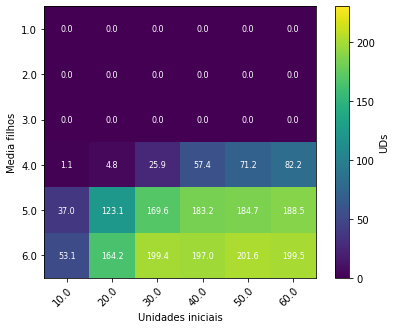

In [32]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values, vmin=0, vmax=230)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

Text(0.5, 0, 'Unidades iniciais')

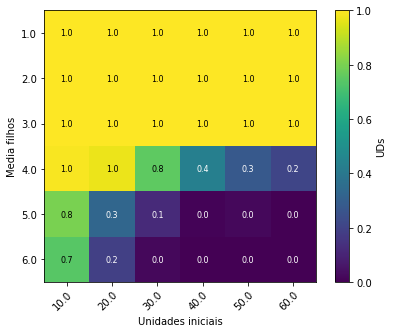

In [33]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['porcentage_extintion'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        value = alive_values[i, j]
        bg_color = IM.cmap(IM.norm(value))
        brightness = (0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2])
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color = 'white' if brightness < 0.5 else 'black', fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

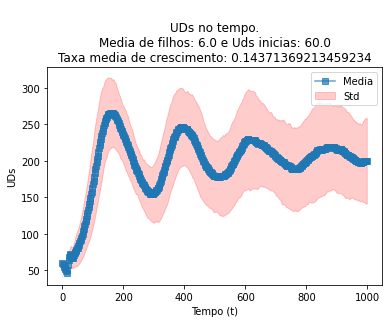

In [34]:
#Graph of experiment with mean and std
x = 5
y = 5

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## 2. UDs fixed

In [54]:
#This experiment has Uds inicias in 40
iniciais = 40
n = 6
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.055 to 0.075
uM = np.empty((len(ualphas), len(ubetas)), dtype=object)
punto_vista = 2
tiempo = 1000
tempo = list(range(0,tiempo,punto_vista))
experiments = 100

start = time.time()
# For data of behaviour
datos_2 = np.empty((len(ualphas), len(ubetas)), dtype=object)
print(uM.shape)

for i, media in enumerate(ualphas):
    for j, prob_morte  in enumerate(ubetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            clanes = [1,2,3]
            clans = (clanes * (int(iniciais) // 3)) + clanes[:(int(iniciais) % 3)]# Just 3 clans
            random.shuffle(clans)
            UD_generalized.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)  
                if not uds_copy:
                    contador += 1
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, 0, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        uM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_2[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {original_media} and beta {prob_morte:.3f} is  {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Generalized_UDin_fixed.npy')
np.save(heat_std, uM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Generalized_Udin_fixed_data.npy')
np.save(behavior, datos_2)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(7, 7)

The total time of the configuration of mean 1.0 and beta 0.045 is  0.13973784446716309
        

The total time of the configuration of mean 1.0 and beta 0.050 is  0.046875
        

The total time of the configuration of mean 1.0 and beta 0.055 is  0.015625715255737305
        

The total time of the configuration of mean 1.0 and beta 0.060 is  0.06179237365722656
        

The total time of the configuration of mean 1.0 and beta 0.065 is  0.026838302612304688
        

The total time of the configuration of mean 1.0 and beta 0.070 is  0.026230335235595703
        

The total time of the configuration of mean 1.0 and beta 0.075 is  0.017755508422851562
        

The total time of the configuration of mean 2.0 and beta 0.045 is  0.04687213897705078
        

The total time of the configuration of mean 2.0 and beta 0.050 is  0.10531783103942871
        

The total time of the configuration of mean 2.0 and beta 0.055 is  0.1491832733154297
        

The total time of the configur

In [55]:
# Dowload the documents
#As reference
n = 6
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Generalized_UDin_fixed.npy')
behavior = os.path.join(folder_name, 'Generalized_UDin_fixed_data.npy')
## heatmap and mean
uM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
uM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

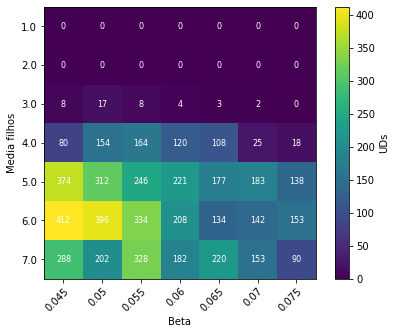

In [56]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

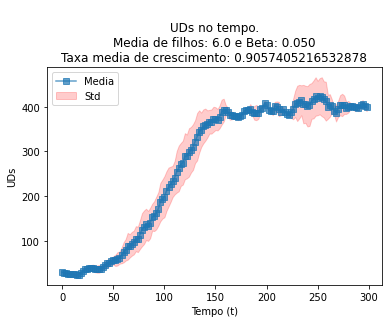

In [57]:
#Graph for each experiment
x = 1
y = 5

# Mean line
plt.plot(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'] - uM_behavior[y][x]['std'],
                 uM_behavior[y][x]['mean'] + uM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {ualphas[y]} e Beta: {ubetas[x]:.3f}
Taxa media de crescimento: {uM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## 3. Mean fixed

In [59]:
#This experiment has mean of children: 4
media = 4
n = 60
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
hM = np.empty((len(halphas), len(hbetas)), dtype=object)
punto_vista = 2
tiempo = 300
tempo = list(range(0,tiempo,punto_vista))
experiments = 2

start = time.time()
# For data of behaviour
datos_3 = np.empty((len(halphas), len(hbetas)), dtype=object)
print(uM.shape)

for i, iniciais in enumerate(halphas):
    for j, prob_morte  in enumerate(hbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        contador = 0
        for experiment in range(1, experiments+1):
            #### Initialization
            clanes = [1,2,3]
            clans = (clanes * (int(iniciais) // 3)) + clanes[:(int(iniciais) % 3)]# Just 3 clans
            random.shuffle(clans)
            UD_generalized.uds = {}
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                    instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
            ## Varieties
            limited_varieties = True
            if limited_varieties == False:
                for id_ud, ud in UD_generalized.uds.items():
                    for _ in range(3):
                        ud.varieties.append(Variety())
            else:
                initial_varieties = [Variety() for _ in range (10)]
                for ud in UD_generalized.uds.values():
                    for _ in range(3):
                        ud.varieties.append(random.choice(initial_varieties))
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
                items = list(uds_copy.items())
                random.shuffle(items)
                uds_copy = dict(items)
                alive = len(uds_copy)
                if alive > 200 and (media == original_media): #or media == original_media-1):
                    media -= media//2
                    if media >= 4:
                        media = media //2
                    #print(media)
                elif alive < 150 and media < original_media:
                    media = original_media
                    #print(media)  
                if not uds_copy:
                    contador += 1
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                for id_ud, ud in uds_copy.items():
                    ud.ter_filho()
                    ud.buscar_ud(uds_copy, media, 0, True, 0.2)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
            # Average Annual Population Growth
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Only before 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        hM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration,
                    'porcentage_extintion': contador/experiments}
        datos_3[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of Initial UDs {iniciais} and beta {prob_morte:.3f} is: {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'Kinship_control_pop'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'Generalized_Mean_fixed.npy')
np.save(heat_std, hM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'Generalized_Mean_fixed_data.npy')
np.save(behavior, datos_3)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(7, 7)

The total time of the configuration of Initial UDs 10.0 and beta 0.050 is: 2.2091784477233887
        

The total time of the configuration of Initial UDs 10.0 and beta 0.055 is: 1.066606044769287
        

The total time of the configuration of Initial UDs 10.0 and beta 0.060 is: 2.142103433609009
        

The total time of the configuration of Initial UDs 10.0 and beta 0.065 is: 0.03315377235412598
        

The total time of the configuration of Initial UDs 10.0 and beta 0.070 is: 0.10831427574157715
        

The total time of the configuration of Initial UDs 10.0 and beta 0.075 is: 0.3013041019439697
        
2
4
2

The total time of the configuration of Initial UDs 20.0 and beta 0.050 is: 7.475293397903442
        
2
4

The total time of the configuration of Initial UDs 20.0 and beta 0.055 is: 3.0060174465179443
        

The total time of the configuration of Initial UDs 20.0 and beta 0.060 is: 3.092921495437622
        

The total time of the configuration of Initial U

In [60]:
# Dowload the documents
#As reference
n = 60
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'Kinship_control_pop'
heat_std = os.path.join(folder_name, 'Generalized_Mean_fixed.npy')
behavior = os.path.join(folder_name, 'Generalized_Mean_fixed_data.npy')
## heatmap and mean
hM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
hM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

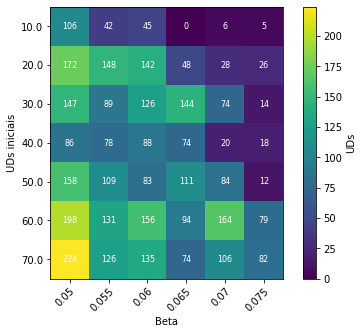

In [61]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

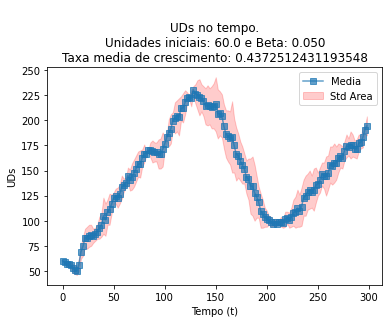

In [62]:
x = 0
y = 5

# MEan line
plt.plot(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'] - hM_behavior[y][x]['std'],
                 hM_behavior[y][x]['mean'] + hM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std Area')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Unidades iniciais: {halphas[y]} e Beta: {hbetas[x]:.3f}
Taxa media de crescimento: {hM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()